In [1]:
# import libraries 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import StratifiedKFold  # Ensure this import is included
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Hyperparameter tuning library
import keras_tuner as kt
print("Imported all required libraries.")

Imported all required libraries.


In [2]:
# API's
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense

In [3]:
# objective: This project aim is to identity whether it is "Defect" or "Good tyre"

In [4]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224
K_FOLDS = 5

print("Configured global variables:")
print(f"BATCH_SIZE = {BATCH_SIZE}, IMG_HEIGHT = {IMG_HEIGHT}, IMG_WIDTH = {IMG_WIDTH}, K_FOLDS = {K_FOLDS}")

Configured global variables:
BATCH_SIZE = 8, IMG_HEIGHT = 224, IMG_WIDTH = 224, K_FOLDS = 5


In [5]:
# Replace 'data' with the path to your dataset directory
dataset_path = 'data'

dataset = image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)
print("Dataset loaded successfully.")

Found 40 files belonging to 2 classes.
Dataset loaded successfully.


In [15]:
# importing - visualize
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
print("Importing other libraries and tools")

Importing other libraries and tools


In [16]:
# convert - images and labels
def get_images_and_labels(dataset):
    print("Imported these libraries")
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

In [12]:
images, labels = get_images_and_labels(dataset)
print("Images:", images)
print("Labels:", labels)

Images: [[[[ 76.12096   69.12096   61.12096 ]
   [ 91.82993   82.83355   75.83174 ]
   [ 84.7336    74.7336    65.7336  ]
   ...
   [123.40247  121.15687  109.27967 ]
   [140.12291  131.17201  122.14746 ]
   [136.7305   127.7796   118.75505 ]]

  [[ 71.29464   64.3683    56.34375 ]
   [ 86.484375  75.484375  69.484375]
   [121.60326  111.60326  102.60326 ]
   ...
   [ 96.616425  93.616425  84.616425]
   [126.53171  119.38439  109.45805 ]
   [124.81223  115.81223  108.81223 ]]

  [[ 64.3952    60.395203  51.395203]
   [ 84.21194   73.21194   67.21194 ]
   [127.26338  117.26338  107.26338 ]
   ...
   [ 76.96714   78.96714   67.7216  ]
   [ 72.7432    72.7432    60.7432  ]
   [ 77.27007   77.27007   67.51561 ]]

  ...

  [[129.02153  110.02154  104.02154 ]
   [127.07366  108.07366  102.07366 ]
   [132.0151   113.01511  109.01511 ]
   ...
   [ 71.03266   74.03266   63.032658]
   [ 66.212135  69.212135  60.212135]
   [ 63.877197  66.8772    55.877197]]

  [[129.97545  112.82799  105.90172 ]

In [18]:
# EDA Concept
def explore_dataset(dataset, dataset_name):
    print(f"\n--- Exploring {dataset_name} Dataset ---")
    
    # Get class counts
    class_counts = Counter([label.numpy() for _, label in dataset.unbatch()])
    print(f"Class Distribution in {dataset_name} Dataset:")
    for cls, count in class_counts.items():
        class_name = "Defective" if cls == 0 else "Good"
        print(f"Class {cls} ({class_name}): {count} samples")
    
    # Bar plot of class distribution
    plt.figure(figsize=(6, 4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title(f"{dataset_name} Dataset Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks([0, 1], ['Defective', 'Good'])
    plt.show()
    
    # Display some sample images
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        num_images = min(len(images), 9)  # Ensure we don't access more images than available
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            cls_name = 'Defective' if labels[i] == 0 else 'Good'
            plt.title(f"Class: {cls_name}")
            plt.axis("off")
    plt.suptitle(f"Sample Images from {dataset_name} Dataset", fontsize=16)
    plt.show()


--- Exploring Complete Dataset ---
Class Distribution in Complete Dataset:
Class 0 (Defective): 20 samples
Class 1 (Good): 20 samples


C:\Users\sripa\AppData\Local\Temp\ipykernel_11192\421593218.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


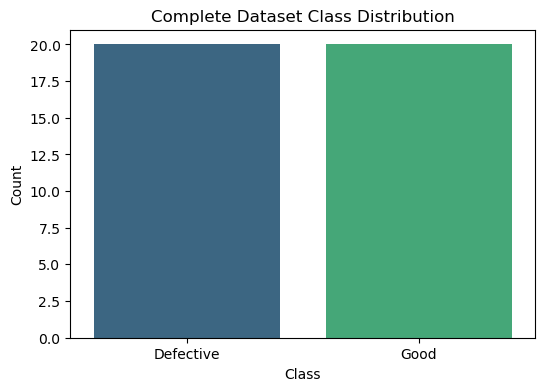

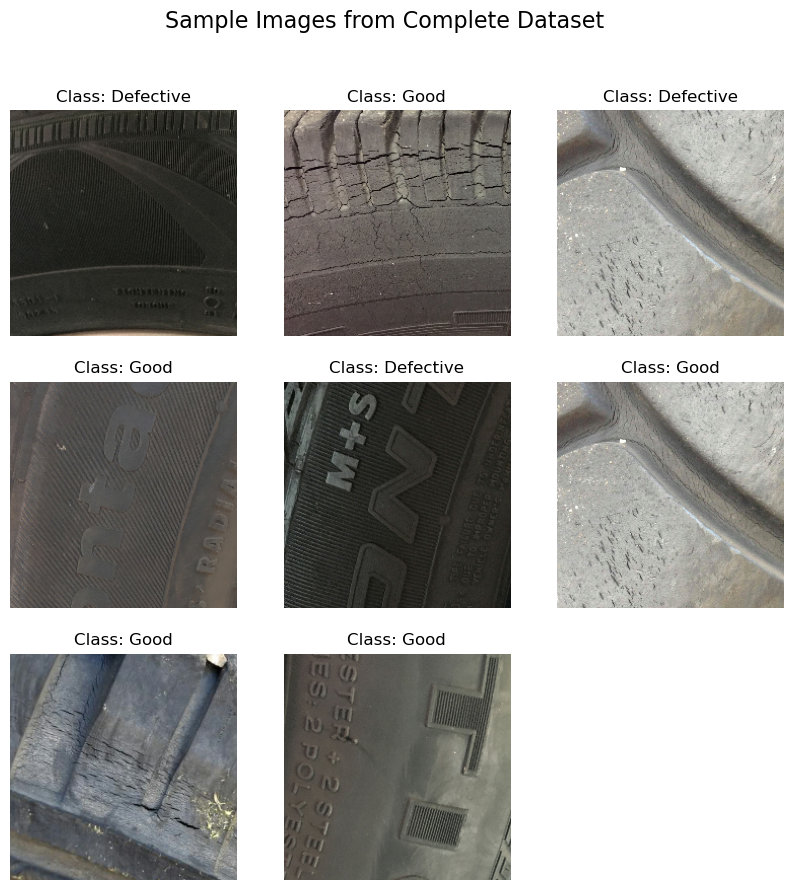

In [19]:
# perform EDA on the dataset
explore_dataset(dataset, "Complete")

In [26]:
# Define Data Augmentation transformations # augmentation & normalization
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.1),
    RandomZoom(0.1),
    RandomContrast(0.1)
])
print("Data augmentation transformations defined")

Data augmentation transformations defined


In [27]:
# Preprocessing the image
def preprocess_image(image, label):
    image = data_augmentation(image)
    image = Rescaling(1./255)(image)
    return image, label
dataset = dataset.map(preprocess_image)
print("Preprocessing complete.")

Preprocessing complete.


In [28]:
# Performance improvement
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
print("Performance optimization complete.")

Performance optimization complete.


In [29]:
# Hyperparameter tuning model to find the accuracy
def model_builder(hp):
    base_model = VGG16(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    print("Model compiled")
    return model

In [30]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='tuner_dir',
                     project_name='product_classifier_tuning')

Reloading Tuner from tuner_dir\product_classifier_tuning\tuner0.json


In [31]:
# Extracting images and labels
def get_images_and_labels(dataset):
    images = []
    labels = []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return np.array(images), np.array(labels)

In [32]:
images, labels = get_images_and_labels(dataset)

In [51]:
# cross-validation with hyperparameter tuning
kf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)
fold_no = 1
accuracies, precisions, recalls, f1s = [], [], [], []

for train_index, val_index in kf.split(images, labels):
    print(f"--- Fold {fold_no} ---")
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]
    
    train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(BATCH_SIZE)
    val_data = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(BATCH_SIZE)

    train_data = train_data.map(preprocess_image).cache().prefetch(buffer_size=AUTOTUNE)
    val_data = val_data.map(preprocess_image).cache().prefetch(buffer_size=AUTOTUNE)

    tuner.search(train_data, validation_data=val_data, epochs=10)
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best hyperparameters for fold {fold_no}: Learning rate: {best_hps.get('learning_rate')}")

    model = tuner.hypermodel.build(best_hps)
    history = model.fit(train_data, validation_data=val_data, epochs=10)
    model.save_weights(f'defectgoodtyre_classifier_fold_{fold_no}.weights.h5')

    # Evaluate the model
    val_predictions = np.argmax(model.predict(val_data), axis=-1)
    val_true = np.concatenate([y for x, y in val_data], axis=0)

    accuracies.append(accuracy_score(val_true, val_predictions))
    precisions.append(precision_score(val_true, val_predictions))
    recalls.append(recall_score(val_true, val_predictions))
    f1s.append(f1_score(val_true, val_predictions))

    fold_no += 1
    tf.keras.backend.clear_session()

--- Fold 1 ---
Best hyperparameters for fold 1: Learning rate: 0.0001
Model compiled
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5583 - loss: 0.9741 - val_accuracy: 0.5000 - val_loss: 0.9407
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3625 - loss: 1.2128 - val_accuracy: 0.5000 - val_loss: 0.7400
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2542 - loss: 0.9855 - val_accuracy: 0.5000 - val_loss: 0.8133
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.6583 - loss: 0.7180 - val_accuracy: 0.5000 - val_loss: 0.7027
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5208 - loss: 0.9143 - val_accuracy: 0.5000 - val_loss: 0.7442
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3750 - loss: 0.9840 - val_accuracy: 0.5000 - val_loss: 0.6998
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5125 - loss: 0.7756 - val_accuracy: 0.5000 - val_loss: 0.7174
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accur

c:\Users\sripa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Fold 3 ---
Best hyperparameters for fold 3: Learning rate: 0.0001
Model compiled
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.6083 - loss: 0.9288 - val_accuracy: 0.5000 - val_loss: 0.7343
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3250 - loss: 1.2959 - val_accuracy: 0.5000 - val_loss: 0.8012
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4542 - loss: 0.8857 - val_accuracy: 0.5000 - val_loss: 0.7523
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5292 - loss: 0.9526 - val_accuracy: 0.5000 - val_loss: 0.7406
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4583 - loss: 0.8547 - val_accuracy: 0.5000 - val_loss: 0.7386
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5500 - loss: 0.8237 - val_accuracy: 0.5000 - val_loss: 0.7230
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3625 - loss: 0.9022 - val_accuracy: 0.5000 - val_loss: 0.7261
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accu

c:\Users\sripa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Fold 4 ---
Best hyperparameters for fold 4: Learning rate: 0.0001
Model compiled
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.4167 - loss: 1.2926 - val_accuracy: 0.5000 - val_loss: 0.8993
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5208 - loss: 0.8622 - val_accuracy: 0.5000 - val_loss: 1.1138
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.3708 - loss: 1.2221 - val_accuracy: 0.5000 - val_loss: 0.6977
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5375 - loss: 0.8550 - val_accuracy: 0.5000 - val_loss: 0.8669
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5458 - loss: 0.8780 - val_accuracy: 0.5000 - val_loss: 0.7083
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5917 - loss: 0.8208 - val_accuracy: 0.5000 - val_loss: 0.8648
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5708 - loss: 0.8700 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accu

c:\Users\sripa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


--- Fold 5 ---
Best hyperparameters for fold 5: Learning rate: 0.0001
Model compiled
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.4000 - loss: 1.1094 - val_accuracy: 0.5000 - val_loss: 1.4136
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4125 - loss: 1.5981 - val_accuracy: 0.5000 - val_loss: 0.7232
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.3958 - loss: 0.9821 - val_accuracy: 0.5000 - val_loss: 0.8998
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5375 - loss: 0.8745 - val_accuracy: 0.5000 - val_loss: 0.7097
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4000 - loss: 0.9953 - val_accuracy: 0.5000 - val_loss: 0.8968
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.4792 - loss: 0.9362 - val_accuracy: 0.5000 - val_loss: 0.6982
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.4083 - loss: 0.8554 - val_accuracy: 0.5000 - val_loss: 0.7210
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accu

In [54]:
# Calculate average metrics
average_accuracy = np.mean(accuracies)
average_precision = np.mean(precisions)
average_recall = np.mean(recalls)
average_f1 = np.mean(f1s)

In [60]:
# Business impact analysis
def business_impact_report():
    print("\nBusiness Impact Report")
    print(f"Final Average Test Accuracy: {average_accuracy:.2f}")
    print(f"Final Average Precision: {average_precision:.2f}")
    print(f"Final Average Recall: {average_recall:.2f}")
    print(f"Final Average F1 Score: {average_f1:.2f}")
    print("Projected Business Benefits:")
    print(f"Reduction in defective products by {average_accuracy * 100:.2f}%.")

In [61]:
# Generate the report
business_impact_report()


Business Impact Report
Final Average Test Accuracy: 0.50
Final Average Precision: 0.20
Final Average Recall: 0.40
Final Average F1 Score: 0.27
Projected Business Benefits:
Reduction in defective products by 50.00%.


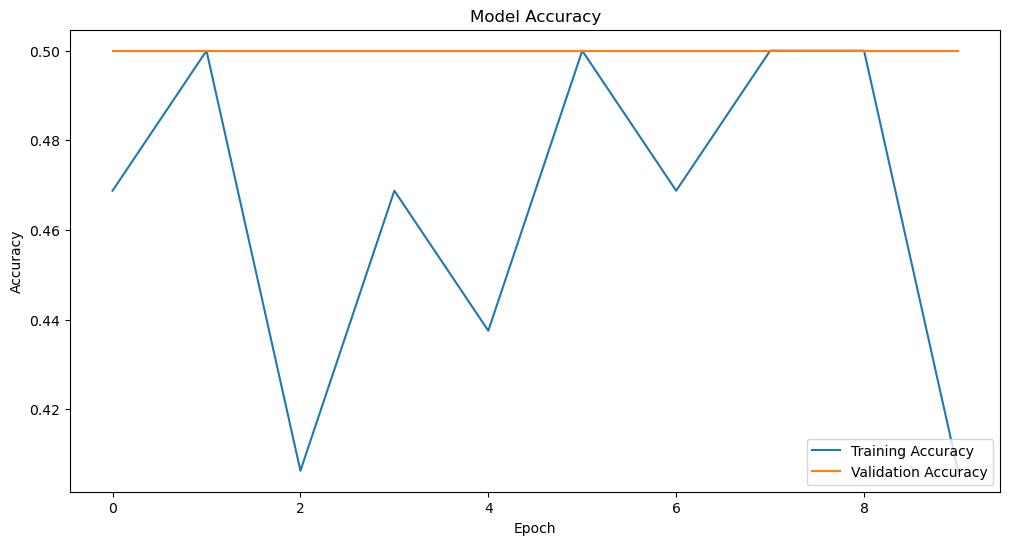

In [63]:
# Visualize training and validation performance
def plot_training_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()
plot_training_history(history)